In [1]:
import numpy as np
import xarray as xa
from matplotlib import pyplot as plt
from scipy.stats import gamma, genpareto, norm
from scipy import optimize
import scipy.stats as st
from tqdm import tqdm

In [2]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)

data = xa.open_dataarray(
    "../cpc-global/NAM_sub_precip", engine='netcdf4')  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))

/global/homes/d/duan0000/.conda/envs/duan/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [3]:
def genpareto_objective_fn(theta, x, dis_func):
    scale = theta[-1]
    loc = 1 # starts from 1
    x = (np.asarray(x)-loc) / scale
    a = theta[0]
    args = (a, scale)
    pdf = dis_func.pdf(x, a)/scale
    logpdf = np.log(pdf)
    return -np.sum(logpdf, axis=0)

def genpareto_nnlf_and_penalty(x, args, dis_func):
    a = args[0]
    scale = args[-1]
    cond0 = (dis_func.a<=x)&(x<=dis_func.b)
    n_bad = np.count_nonzero(cond0, axis=0)
    pdf = dis_func.pdf(x, a)/scale
    logpdf = np.log(pdf)
    logpdf = dis_func.logpdf(x, a, loc=0, scale=scale)
    finite_logpdf = np.isfinite(logpdf)
    # print(np.sum(finite_logpdf))
    n_bad += np.sum(~finite_logpdf, axis=0)
    # print(np.sum(pdf))
    return -np.sum(logpdf, axis=0) # negative log liklihood

def genpareto_penalized_nnlf(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = theta[0]
    scale = theta[-1]
    # print(args, scale)
    loc = 1
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    if a<0:
        shape_penalty = 1000
    else:
        shape_penalty = 0
    args = (a, scale)
    return genpareto_nnlf_and_penalty(x, args, dis_func) + n_log_scale + shape_penalty

def fit_genpareto_parameters(data, dis_func):
    function = genpareto_penalized_nnlf
    start = dis_func._fitstart(data)
    # print(start)
    args = optimize.fmin(func=function, x0=(0, start[-1]), args=(np.ravel(data), dis_func), disp=0, maxiter=500)
    # print(args)
    return args

In [4]:
def gamma_objective_fn(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = args[0]
    scale = theta[-1]
    loc = 0 # starts from 0
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    args = (a, scale)
    return gamma_nnlf_and_penalty(x, args, dis_func)

def gamma_nnlf_and_penalty(x, args, dis_func):
    a = args[0]
    scale = args[-1]
    cond0 = (dis_func.a<=x)&(x<=dis_func.b)
    n_bad = np.count_nonzero(cond0, axis=0)
    pdf = dis_func.pdf(x, a, scale=1)/scale
    total_pdf = 1 - dis_func.cdf(1, a, loc=0, scale=scale) # from 1 to inf
    pdf = pdf/total_pdf
    logpdf = np.log(pdf)
    finite_logpdf = np.isfinite(logpdf)
    n_bad += np.sum(~finite_logpdf, axis=0)
    # print(np.sum(pdf))
    return -np.sum(logpdf, axis=0) # negative log liklihood

def gamma_penalized_nnlf(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = theta[0]
    scale = theta[-1]
    # print(args, scale)
    loc = 0
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    if a>1:
        shape_penalty = 1000
    else:
        shape_penalty = 0
    args = (a, scale)
    return gamma_nnlf_and_penalty(x, args, dis_func) + n_log_scale + shape_penalty

def fit_gamma_parameters(data, dis_func):
    function = gamma_penalized_nnlf
    start = dis_func._fitstart(data)
    # print(start)
    args = optimize.fmin(func=function, x0=(0, start[-1]), args=(np.ravel(data), dis_func), disp=0, maxiter=500)
    # print(args)
    return args
def fit_gamma_genpareto(data, ax, x):
    a1, scale1 = fit_gamma_parameters(data, gamma)
    pdf1 = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
    score_ga = gamma_objective_fn(x=data, theta=(a1, scale1), dis_func=gamma)
    # print('Gamma: ', score_ga)
    if ax is not None:
        ax.plot(x, pdf1, color='red')
    a2, scale2 = fit_genpareto_parameters(data, genpareto)
    pdf2 = genpareto.pdf(x, a2, 1, scale2)
    score_gp = genpareto_objective_fn(x=data, theta=(a2, scale2), dis_func=genpareto)
    # print('GenPareto: ', score_gp)
    if ax is not None:
        ax.plot(x, pdf2, color='blue', label='GenPareto')
    return (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp)
def get_pdf(precip, x):
    (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
    if score_ga<score_gp:
        pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
        dis = 'Gamma'
        print(a1, scale1, dis)
    else:
        pdf = genpareto.pdf(x, a2, 1, scale2)
        dis = 'GenPareto'
        print(a2, scale2, dis)
    return pdf

In [5]:
def get_precip(sub_id):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
    tutt_sub = np.load(str(sub_id)+'_all_TUTT-10degree.npy')
    tutt_type = np.load(str(sub_id)+'_all_TUTT-types-10degree.npy')
    tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
    surge_sub = np.load(str(sub_id)+'_all_surge.npy')
    midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
    mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
    front_sub = np.load(str(sub_id)+'_all_front.npy')
    x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
    tutt_precip = []
    tc_precip = []
    mcs_precip = []
    midtro_precip = []
    front_precip = []
    surge_precip = []
    west_utt_precip = []
    east_utt_precip = []
    # two-way
    tc_tutt_precip = []
    tc_mcs_precip = []
    tc_surge_precip = []
    tc_front_precip = []
    tc_midtro_precip = []
    tutt_mcs_precip = []
    tutt_surge_precip = []
    tutt_midtro_precip = []
    tutt_front_precip = []
    mcs_midtro_precip = []
    mcs_front_precip = []
    mcs_surge_precip = []
    midtro_front_precip = []
    midtro_surge_precip = []
    front_surge_precip = []
    west_utt_mcs_precip = []
    east_utt_mcs_precip = []
    for i in range(sub_precip.shape[0]):
        if tutt_sub[i]>0:
            tutt_precip.append(sub_precip[i])
            if tutt_type[i]>0:
                west_utt_precip.append(sub_precip[i])
            if tutt_type[i]<0:
                east_utt_precip.append(sub_precip[i])
        if tc_sub[i]>0:
            tc_precip.append(sub_precip[i])
        if surge_sub[i]>0:
            surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0:
            mcs_precip.append(sub_precip[i])
        if front_sub[i]>0:
            front_precip.append(sub_precip[i])
        if midtro_sub[i]>0:
            midtro_precip.append(sub_precip[i])
        # 2-way
        if midtro_sub[i]>0 and front_sub[i]>0:
            midtro_front_precip.append(sub_precip[i])
        if midtro_sub[i]>0 and surge_sub[i]>0:
            midtro_surge_precip.append(sub_precip[i])
        if surge_sub[i]>0 and front_sub[i]>0:
            front_surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and front_sub[i]>0:
            mcs_front_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and midtro_sub[i]>0:
            mcs_midtro_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and surge_sub[i]>0:
            mcs_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and tutt_sub[i]>0:
            tc_tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0 and front_sub[i]>0:
            tc_front_precip.append(sub_precip[i])
        if tc_sub[i]>0 and surge_sub[i]>0:
            tc_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and midtro_sub[i]>0:
            tc_midtro_precip.append(sub_precip[i])
        if tc_sub[i]>0 and mcs_sub[i]>0:
            tc_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and front_sub[i]>0:
            tutt_front_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and mcs_sub[i]>0:
            tutt_mcs_precip.append(sub_precip[i])
            if tutt_type[i]>0:
                west_utt_mcs_precip.append(sub_precip[i])
            if tutt_type[i]<0:
                east_utt_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and surge_sub[i]>0:
            tutt_surge_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and midtro_sub[i]>0:
            tutt_midtro_precip.append(sub_precip[i])
        two_way_precip = [tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
                      tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
                      mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
                      midtro_front_precip, midtro_surge_precip,
                      front_surge_precip, west_utt_mcs_precip, east_utt_mcs_precip]
    return [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip, west_utt_precip, east_utt_precip], \
            two_way_precip

In [6]:
two_way_names = ['tc_tutt', 'tc_mcs', 'tc_surge', 'tc_front', 'tc_midtro',
                 'tutt_mcs', 'tutt_surge', 'tutt_midtro', 'tutt_front',
                 'mcs_midtro', 'mcs_front', 'mcs_surge',
                 'midtro_front', 'midtro_surge',
                 'front_surge',]
names = ['mcs', 'tc', 'surge', 'front', 'midtro', 'tutt']

# Sub7

In [7]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip, west_utt_precip, east_utt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip, west_utt_mcs_precip, east_utt_mcs_precip] = get_precip(sub_id=7)
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))
sub_precip = monsoon_precip.sel(sub_id=7)
sub_precip = sub_precip[sub_precip>1]
threshold = np.quantile(sub_precip, .95)
print(threshold)
x = np.logspace(1, np.log(threshold*2), num=100, base=np.e)

160
9
14
50
50
17.252742222601025


In [8]:
print(len(tc_precip))
print(len(tutt_precip))
print(len(tc_midtro_precip))

178
1175
9


In [9]:
print(len(east_utt_precip))
print(len(west_utt_precip))
print(len(east_utt_mcs_precip))
print(len(west_utt_mcs_precip))

258
917
81
317


In [10]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_precip, None, x)
print(score_ga, score_gp)
west_utt_pdf = pdf1

2748.148287454792 2848.1810471833896


In [11]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_mcs_precip, None, x)
print(score_ga, score_gp)
west_utt_mcs_pdf = pdf1

970.4781435307763 1029.5373858320968


In [12]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
print(score_ga, score_gp)
mcs_pdf = pdf1

3006.5527450646796 3268.9565119350464


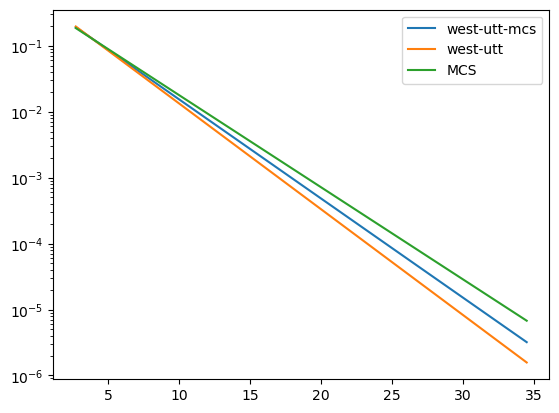

In [13]:
plt.plot(x, west_utt_mcs_pdf, label='west-utt-mcs')
plt.plot(x, west_utt_pdf, label='west-utt')
plt.plot(x, mcs_pdf, label='MCS')
plt.legend()
plt.yscale('log')
plt.show()

In [14]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_precip, None, x)
print(score_ga, score_gp)
east_utt_pdf = pdf2

781.4887267826861 749.9407244340952


In [15]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_mcs_precip, None, x)
print(score_ga, score_gp)
east_utt_mcs_pdf = pdf1

249.79043204277437 268.5673376497854


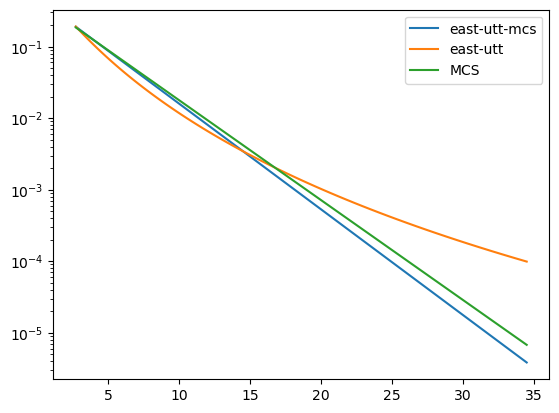

In [16]:
plt.plot(x, east_utt_mcs_pdf, label='east-utt-mcs')
plt.plot(x, east_utt_pdf, label='east-utt')
plt.plot(x, mcs_pdf, label='MCS')
plt.legend()
plt.yscale('log')
plt.show()

In [17]:
pdfs_tc = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_precip, size=len(tc_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc.append(pdf1)
    else:
        pdfs_tc.append(pdf2)

pdfs_tc = np.array(pdfs_tc)
print(pdfs_tc.shape)

100%|██████████| 200/200 [00:19<00:00, 10.07it/s]

(200, 100)


In [18]:
print(len(tc_tutt_precip))

50


In [19]:
pdfs_tc_tutt = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_tutt_precip, size=len(tc_tutt_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc_tutt.append(pdf1)
    else:
        pdfs_tc_tutt.append(pdf2)

pdfs_tc_tutt = np.array(pdfs_tc_tutt)
print(pdfs_tc_tutt.shape)

  7%|▋         | 14/200 [00:01<00:18, 10.27it/s]/tmp/ipykernel_1110148/498137889.py:33: RuntimeWarning: invalid value encountered in log
  n_log_scale = len(x) * np.log(scale)
100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

(200, 100)


In [20]:
arg1 = []
arg2 = []
pdfs_tutt = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tutt_precip, size=len(tutt_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tutt.append(pdf1)
    else:
        pdfs_tutt.append(pdf2)

pdfs_tutt = np.array(pdfs_tutt)
print(pdfs_tutt.shape)

100%|██████████| 200/200 [00:28<00:00,  7.12it/s]

(200, 100)


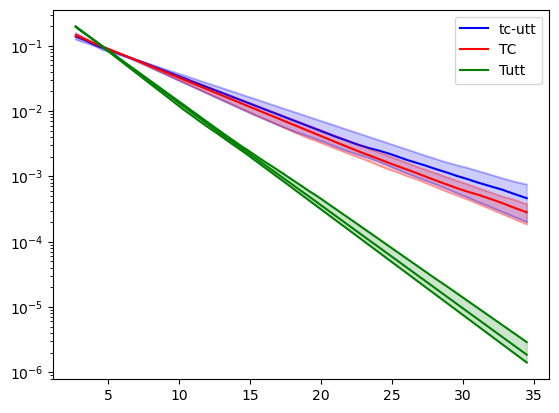

In [21]:
plt.plot(x, np.median(pdfs_tc_tutt, axis=0), label='tc-utt', color='blue')
plt.plot(x, np.quantile(pdfs_tc_tutt, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc_tutt, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc_tutt, axis=0, q=.25), np.quantile(pdfs_tc_tutt, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_tc, axis=0), label='TC', color='red')
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc, axis=0, q=.25), np.quantile(pdfs_tc, axis=0, q=.75), alpha=0.2, color='red')
plt.plot(x, np.median(pdfs_tutt, axis=0), label='Tutt', color='green')
plt.plot(x, np.quantile(pdfs_tutt, axis=0, q=.25), color='green')
plt.plot(x, np.quantile(pdfs_tutt, axis=0, q=.75), color='green')
plt.fill_between(x, np.quantile(pdfs_tutt, axis=0, q=.25), np.quantile(pdfs_tutt, axis=0, q=.75), alpha=0.2, color='green')
plt.legend()
plt.show()

In [22]:
print(len(tc_surge_precip))

160


In [23]:
arg1 = []
arg2 = []
pdfs_tc_surge = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_surge_precip, size=len(tc_surge_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc_surge.append(pdf1)
    else:
        pdfs_tc_surge.append(pdf2)
pdfs_tc_surge = np.array(pdfs_tc_surge)
print(pdfs_tc_surge.shape)

100%|██████████| 200/200 [00:18<00:00, 10.56it/s]

(200, 100)


In [24]:
pdfs_surge = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(surge_precip, size=len(tc_surge_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_surge.append(pdf1)
    else:
        pdfs_surge.append(pdf2)
pdfs_surge = np.array(pdfs_surge)
print(pdfs_surge.shape)

100%|██████████| 200/200 [00:22<00:00,  8.73it/s]

(200, 100)


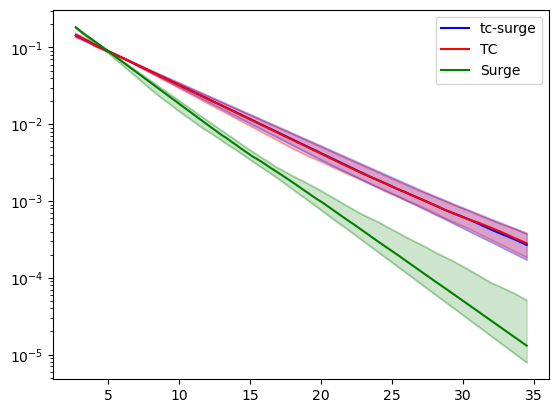

In [25]:
plt.plot(x, np.median(pdfs_tc_surge, axis=0), label='tc-surge', color='blue')
plt.plot(x, np.quantile(pdfs_tc_surge, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc_surge, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc_surge, axis=0, q=.25), np.quantile(pdfs_tc_surge, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_tc, axis=0), label='TC', color='red')
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc, axis=0, q=.25), np.quantile(pdfs_tc, axis=0, q=.75), alpha=0.2, color='red')
plt.plot(x, np.median(pdfs_surge, axis=0), label='Surge', color='green')
plt.plot(x, np.quantile(pdfs_surge, axis=0, q=.25), color='green', alpha=0.2)
plt.plot(x, np.quantile(pdfs_surge, axis=0, q=.75), color='green', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_surge, axis=0, q=.25), np.quantile(pdfs_surge, axis=0, q=.75), alpha=0.2, color='green')
plt.legend()
plt.show()

In [26]:
print(len(tc_mcs_precip))

50


In [27]:
pdfs_tc_mcs = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_mcs_precip, size=len(tc_mcs_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc_mcs.append(pdf1)
    else:
        pdfs_tc_mcs.append(pdf2)

pdfs_tc_mcs = np.array(pdfs_tc_mcs)
print(pdfs_tc_mcs.shape)

100%|██████████| 200/200 [00:17<00:00, 11.13it/s]

(200, 100)


In [28]:
pdfs_mcs = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(mcs_precip, size=len(mcs_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_mcs.append(pdf1)
    else:
        pdfs_mcs.append(pdf2)

pdfs_mcs = np.array(pdfs_mcs)
print(pdfs_mcs.shape)

100%|██████████| 200/200 [00:25<00:00,  7.97it/s]

(200, 100)


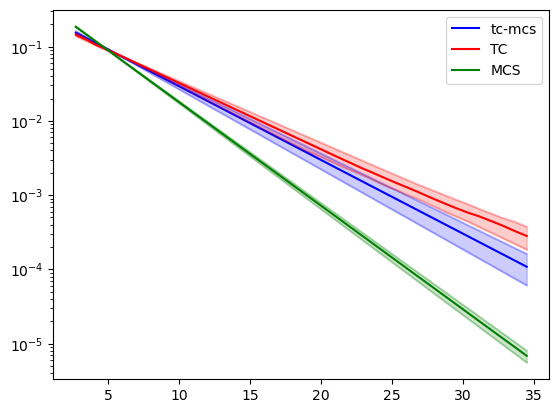

In [29]:
plt.plot(x, np.nanmedian(pdfs_tc_mcs, axis=0), label='tc-mcs', color='blue')
plt.plot(x, np.nanquantile(pdfs_tc_mcs, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.nanquantile(pdfs_tc_mcs, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.nanquantile(pdfs_tc_mcs, axis=0, q=.25), np.nanquantile(pdfs_tc_mcs, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_tc, axis=0), label='TC', color='red')
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc, axis=0, q=.25), np.quantile(pdfs_tc, axis=0, q=.75), alpha=0.2, color='red')
plt.plot(x, np.median(pdfs_mcs, axis=0), label='MCS', color='green')
plt.plot(x, np.quantile(pdfs_mcs, axis=0, q=.25), color='green', alpha=0.2)
plt.plot(x, np.quantile(pdfs_mcs, axis=0, q=.75), color='green', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_mcs, axis=0, q=.25), np.quantile(pdfs_mcs, axis=0, q=.75), alpha=0.2, color='green')
plt.legend()
plt.show()

# Sub6

In [30]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip, west_utt_precip, east_utt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip, west_utt_mcs_precip, east_utt_mcs_precip] = get_precip(sub_id=6)
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))
sub_precip = monsoon_precip.sel(sub_id=6)
sub_precip = sub_precip[sub_precip>1]
threshold = np.quantile(sub_precip, .95)
print(threshold)
x = np.logspace(1, np.log(threshold*2), num=100, base=np.e)

84
10
15
15
21
10.647874758983226


In [31]:
print(len(east_utt_precip))
print(len(west_utt_precip))
print(len(east_utt_mcs_precip))
print(len(west_utt_mcs_precip))

346
768
76
231


In [32]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_precip, None, x)
print(score_ga, score_gp)
west_utt_pdf = pdf2

1900.5513668992799 1796.2004002782305


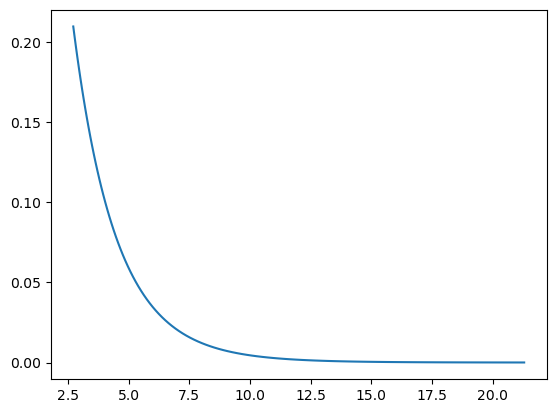

In [33]:
plt.plot(x, west_utt_pdf)

In [34]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_mcs_precip, None, x)
print(score_ga, score_gp)
west_utt_mcs_pdf = pdf2

610.2192345067657 592.1283448201054


In [35]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
print(score_ga, score_gp)
mcs_pdf = pdf2

1644.2329572740482 1627.8885070131932


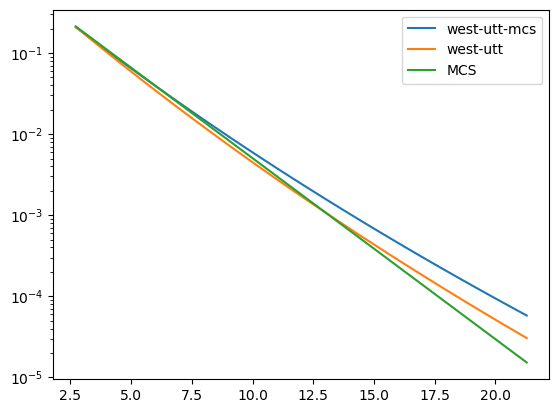

In [36]:
plt.plot(x, west_utt_mcs_pdf, label='west-utt-mcs')
plt.plot(x, west_utt_pdf, label='west-utt')
plt.plot(x, mcs_pdf, label='MCS')
plt.legend()
plt.yscale('log')
plt.show()

In [37]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_mcs_precip, None, x)
print(score_ga, score_gp)
east_utt_mcs_pdf = pdf2

194.30771367252365 189.4857635591794


In [38]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_precip, None, x)
print(score_ga, score_gp)
east_utt_pdf = pdf2

835.6817643341286 756.3498376135728


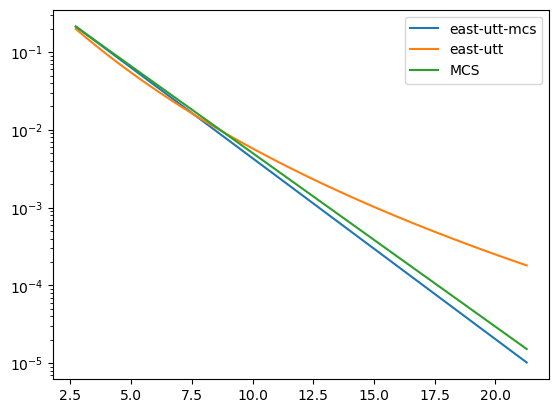

In [39]:
plt.plot(x, east_utt_mcs_pdf, label='east-utt-mcs')
plt.plot(x, east_utt_pdf, label='east-utt')
plt.plot(x, mcs_pdf, label='MCS')
plt.legend()
plt.yscale('log')
plt.show()

In [40]:
pdfs_tc = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_precip, size=len(tc_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc.append(pdf1)
    else:
        pdfs_tc.append(pdf2)

pdfs_tc = np.array(pdfs_tc)
print(pdfs_tc.shape)

 51%|█████     | 102/200 [00:09<00:09, 10.63it/s]/tmp/ipykernel_1110148/498137889.py:33: RuntimeWarning: invalid value encountered in log
  n_log_scale = len(x) * np.log(scale)
100%|██████████| 200/200 [00:17<00:00, 11.20it/s]

(200, 100)


In [41]:
print(len(tc_tutt_precip))

21


In [42]:
pdfs_tc_tutt = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_tutt_precip, size=len(tc_tutt_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc_tutt.append(pdf1)
    else:
        pdfs_tc_tutt.append(pdf2)

pdfs_tc_tutt = np.array(pdfs_tc_tutt)
print(pdfs_tc_tutt.shape)

 10%|█         | 21/200 [00:01<00:16, 11.02it/s]/tmp/ipykernel_1110148/498137889.py:33: RuntimeWarning: invalid value encountered in log
  n_log_scale = len(x) * np.log(scale)
100%|██████████| 200/200 [00:18<00:00, 10.98it/s]

(200, 100)


In [43]:
pdfs_tutt = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tutt_precip, size=len(tutt_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tutt.append(pdf1)
    else:
        pdfs_tutt.append(pdf2)

pdfs_tutt = np.array(pdfs_tutt)
print(pdfs_tutt.shape)

100%|██████████| 200/200 [00:26<00:00,  7.62it/s]

(200, 100)


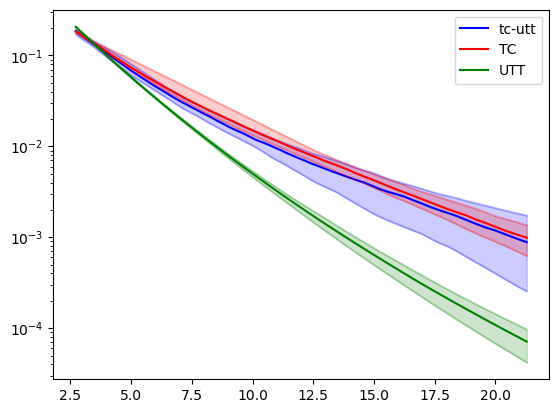

In [44]:
plt.plot(x, np.median(pdfs_tc_tutt, axis=0), label='tc-utt', color='blue')
plt.plot(x, np.quantile(pdfs_tc_tutt, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc_tutt, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc_tutt, axis=0, q=.25), np.quantile(pdfs_tc_tutt, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_tc, axis=0), label='TC', color='red')
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc, axis=0, q=.25), np.quantile(pdfs_tc, axis=0, q=.75), alpha=0.2, color='red')
plt.plot(x, np.median(pdfs_tutt, axis=0), label='UTT', color='green')
plt.plot(x, np.quantile(pdfs_tutt, axis=0, q=.25), color='green', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tutt, axis=0, q=.75), color='green', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tutt, axis=0, q=.25), np.quantile(pdfs_tutt, axis=0, q=.75), alpha=0.2, color='green')
plt.legend()
plt.show()

In [45]:
print(len(tc_mcs_precip))

15


In [46]:
arg1 = []
arg2 = []
pdfs_tc_mcs = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_mcs_precip, size=len(tc_mcs_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc_mcs.append(pdf1)
    else:
        pdfs_tc_mcs.append(pdf2)

pdfs_tc_mcs = np.array(pdfs_tc_mcs)
print(pdfs_tc_mcs.shape)

100%|██████████| 200/200 [00:18<00:00, 10.66it/s]

(200, 100)


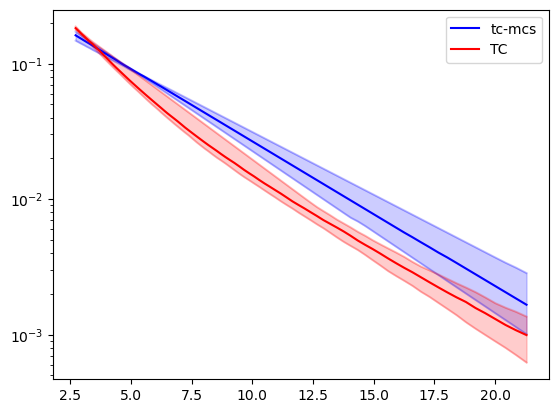

In [47]:
plt.plot(x, np.nanmedian(pdfs_tc_mcs, axis=0), label='tc-mcs', color='blue')
plt.plot(x, np.nanquantile(pdfs_tc_mcs, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.nanquantile(pdfs_tc_mcs, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.nanquantile(pdfs_tc_mcs, axis=0, q=.25), np.nanquantile(pdfs_tc_mcs, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_tc, axis=0), label='TC', color='red')
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc, axis=0, q=.25), np.quantile(pdfs_tc, axis=0, q=.75), alpha=0.2, color='red')
plt.legend()
plt.show()

In [48]:
print(len(tc_surge_precip))
pdfs_tc_surge = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_surge_precip, size=len(tc_surge_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc_surge.append(pdf1)
    else:
        pdfs_tc_surge.append(pdf2)
pdfs_tc_surge = np.array(pdfs_tc_surge)
print(pdfs_tc_surge.shape)

84


100%|██████████| 200/200 [00:18<00:00, 10.75it/s]

(200, 100)


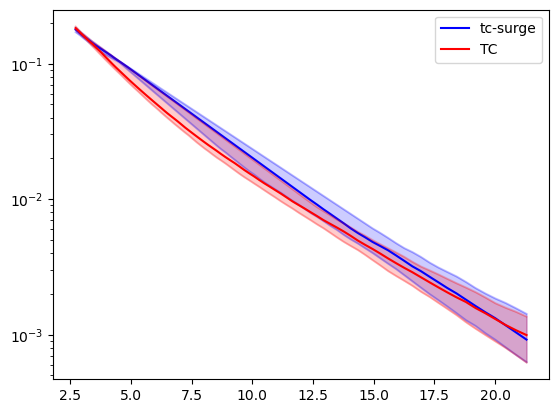

In [49]:
plt.plot(x, np.median(pdfs_tc_surge, axis=0), label='tc-surge', color='blue')
plt.plot(x, np.quantile(pdfs_tc_surge, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc_surge, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc_surge, axis=0, q=.25), np.quantile(pdfs_tc_surge, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_tc, axis=0), label='TC', color='red')
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc, axis=0, q=.25), np.quantile(pdfs_tc, axis=0, q=.75), alpha=0.2, color='red')
plt.legend()
plt.show()

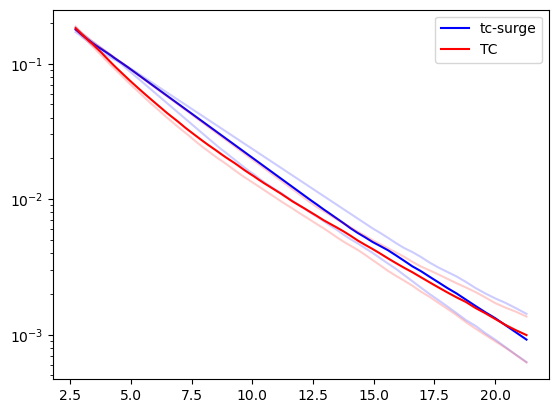

In [50]:
plt.plot(x, np.median(pdfs_tc_surge, axis=0), label='tc-surge', color='blue')
plt.plot(x, np.quantile(pdfs_tc_surge, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc_surge, axis=0, q=.75), color='blue', alpha=0.2)
# plt.fill_between(x, np.quantile(pdfs_tc_surge, axis=0, q=.25), np.quantile(pdfs_tc_surge, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_tc, axis=0), label='TC', color='red')
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.75), color='red', alpha=0.2)
# plt.fill_between(x, np.quantile(pdfs_tc, axis=0, q=.25), np.quantile(pdfs_tc, axis=0, q=.75), alpha=0.2, color='red')
plt.legend()
plt.show()

In [51]:
(a1, scale1), (a2, scale2), (pdf1_tc, pdf2_tc), (score_ga, score_gp) = fit_gamma_genpareto(tc_precip, None, x)
print(score_ga, score_gp)
(a1, scale1), (a2, scale2), (pdf1_tc_surge, pdf2_tc_surge), (score_ga, score_gp) = fit_gamma_genpareto(tc_surge_precip, None, x)
print(score_ga, score_gp)


283.4990739958978 281.32865179158733
272.1347611703085 279.72446081094824


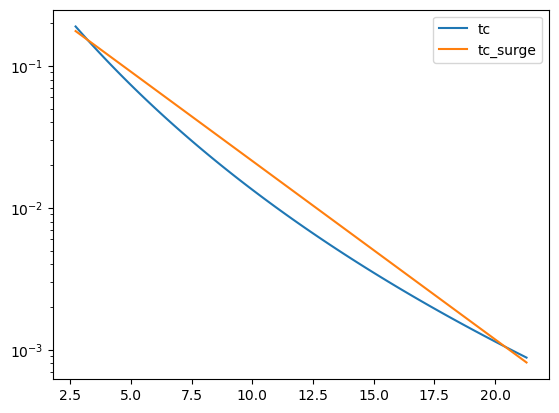

In [52]:
plt.plot(x, pdf2_tc, label='tc')
plt.plot(x, pdf1_tc_surge, label='tc_surge')
plt.legend()
plt.yscale('log')
plt.show()

In [53]:
x = np.logspace(1, np.log(40), num=100, base=np.e)
(a1, scale1), (a2, scale2), (pdf1_tc, pdf2_tc), (score_ga, score_gp) = fit_gamma_genpareto(tc_precip, None, x)
print(score_ga, score_gp)
(a1, scale1), (a2, scale2), (pdf1_tc_surge, pdf2_tc_surge), (score_ga, score_gp) = fit_gamma_genpareto(tc_surge_precip, None, x)
print(score_ga, score_gp)


283.4990739958978 281.32865179158733
272.1347611703085 279.72446081094824


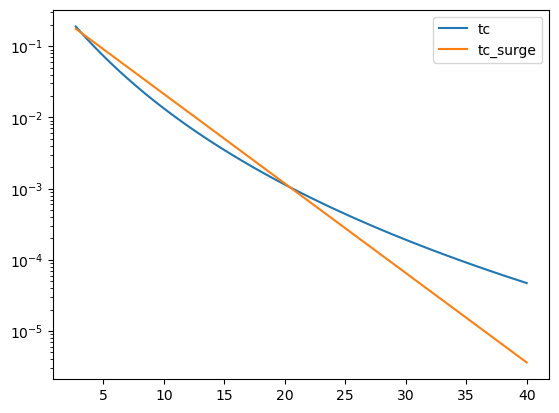

In [54]:
plt.plot(x, pdf2_tc, label='tc')
plt.plot(x, pdf1_tc_surge, label='tc_surge')
plt.legend()
plt.yscale('log')
plt.show()

# Sub1

In [55]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip,] = get_precip(sub_id=1)
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))
sub_precip = monsoon_precip.sel(sub_id=1)
sub_precip = sub_precip[sub_precip>1]
threshold = np.quantile(sub_precip, .95)
print(threshold)

ValueError: too many values to unpack (expected 6)

In [ ]:
pdfs_tc_tutt = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_tutt_precip, size=len(tc_tutt_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc_tutt.append(pdf1)
    else:
        pdfs_tc_tutt.append(pdf2)
pdfs_tc_tutt = np.array(pdfs_tc_tutt)
print(pdfs_tc_tutt.shape)

In [ ]:
pdfs_tc_surge = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_surge_precip, size=len(tc_surge_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc_surge.append(pdf1)
    else:
        pdfs_tc_surge.append(pdf2)
pdfs_tc_surge = np.array(pdfs_tc_surge)
print(pdfs_tc_surge.shape)

In [ ]:
pdfs_tc = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_precip, size=len(tc_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc.append(pdf1)
    else:
        pdfs_tc.append(pdf2)
pdfs_tc = np.array(pdfs_tc)
print(pdfs_tc.shape)

In [ ]:
plt.plot(x, np.median(pdfs_tc_tutt, axis=0), label='Utt-TC', color='blue')
plt.plot(x, np.quantile(pdfs_tc_tutt, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc_tutt, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc_tutt, axis=0, q=.25), np.quantile(pdfs_tc_tutt, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_tc, axis=0), label='TC', color='red')
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc, axis=0, q=.25), np.quantile(pdfs_tc, axis=0, q=.75), alpha=0.2, color='red')
plt.legend()
plt.show()

In [ ]:
plt.plot(x, np.median(pdfs_tc_surge, axis=0), label='surge-TC', color='blue')
plt.plot(x, np.quantile(pdfs_tc_surge, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc_surge, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc_surge, axis=0, q=.25), np.quantile(pdfs_tc_surge, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_tc, axis=0), label='TC', color='red')
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc, axis=0, q=.25), np.quantile(pdfs_tc, axis=0, q=.75), alpha=0.2, color='red')
plt.legend()
plt.show()

In [ ]:
print(len(tc_midtro_precip))
pdfs_tc_midtro = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tc_midtro_precip, size=len(tutt_midtro_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tc_midtro.append(pdf1)
    else:
        pdfs_tc_midtro.append(pdf2)
pdfs_tc_midtro = np.array(pdfs_tc_midtro)
print(pdfs_tc_midtro.shape)

In [ ]:
plt.plot(x, np.median(pdfs_tc_midtro, axis=0), label='TC-Midtro', color='blue')
plt.plot(x, np.quantile(pdfs_tc_midtro, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc_midtro, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc_midtro, axis=0, q=.25), np.quantile(pdfs_tc_midtro, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_tc, axis=0), label='TC', color='red')
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tc, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tc, axis=0, q=.25), np.quantile(pdfs_tc, axis=0, q=.75), alpha=0.2, color='red')
plt.legend()
plt.show()

# Sub5

In [ ]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip, west_utt_precip, east_utt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip, west_utt_mcs_precip, east_utt_mcs_precip] = get_precip(sub_id=5)
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))
sub_precip = monsoon_precip.sel(sub_id=5)
sub_precip = sub_precip[sub_precip>1]
threshold = np.quantile(sub_precip, .95)
print(threshold)
x = np.logspace(1, np.log(threshold*2), num=100, base=np.e)

In [ ]:
print(len(east_utt_precip))
print(len(west_utt_precip))
print(len(east_utt_mcs_precip))
print(len(west_utt_mcs_precip))

In [ ]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_precip, None, x)
print(score_ga, score_gp)
west_utt_pdf = pdf2

In [ ]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_mcs_precip, None, x)
print(score_ga, score_gp)
west_utt_mcs_pdf = pdf2

In [ ]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
print(score_ga, score_gp)
mcs_pdf = pdf2

In [ ]:
plt.plot(x, west_utt_mcs_pdf, label='west-utt-mcs')
plt.plot(x, west_utt_pdf, label='west-utt')
plt.plot(x, mcs_pdf, label='MCS')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_precip, None, x)
print(score_ga, score_gp)
east_utt_pdf = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_mcs_precip, None, x)
print(score_ga, score_gp)
east_utt_mcs_pdf = pdf2

In [ ]:
plt.plot(x, east_utt_mcs_pdf, label='east-utt-mcs')
plt.plot(x, east_utt_pdf, label='east-utt')
plt.plot(x, mcs_pdf, label='MCS')
plt.legend()
plt.yscale('log')
plt.show()

## Midtro

In [ ]:
print(len(midtro_surge_precip))
print(len(tutt_midtro_precip))
print(len(midtro_front_precip))
print(len(mcs_midtro_precip))
print(len(tc_midtro_precip))

In [ ]:
pdfs_tutt_midtro = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tutt_midtro_precip, size=len(tutt_midtro_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tutt_midtro.append(pdf1)
    else:
        pdfs_tutt_midtro.append(pdf2)
pdfs_tutt_midtro = np.array(pdfs_tutt_midtro)
print(pdfs_tutt_midtro.shape)

In [ ]:
pdfs_midtro = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(midtro_precip, size=len(midtro_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_midtro.append(pdf1)
    else:
        pdfs_midtro.append(pdf2)
pdfs_midtro = np.array(pdfs_midtro)
print(pdfs_midtro.shape)

In [ ]:
pdfs_tutt = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tutt_precip, size=len(midtro_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tutt.append(pdf1)
    else:
        pdfs_tutt.append(pdf2)
pdfs_tutt = np.array(pdfs_tutt)
print(pdfs_tutt.shape)

In [ ]:
plt.plot(x, np.median(pdfs_tutt_midtro, axis=0), label='Utt-Midtro', color='blue')
plt.plot(x, np.quantile(pdfs_tutt_midtro, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tutt_midtro, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tutt_midtro, axis=0, q=.25), np.quantile(pdfs_tutt_midtro, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_midtro, axis=0), label='Midtro', color='red')
plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_midtro, axis=0, q=.25), np.quantile(pdfs_midtro, axis=0, q=.75), alpha=0.2, color='red')
plt.plot(x, np.median(pdfs_tutt, axis=0), label='UTT', color='green')
plt.plot(x, np.quantile(pdfs_tutt, axis=0, q=.25), color='green', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tutt, axis=0, q=.75), color='green', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tutt, axis=0, q=.25), np.quantile(pdfs_tutt, axis=0, q=.75), alpha=0.2, color='green')

plt.legend()
plt.show()

In [ ]:
pdfs_front_midtro = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(midtro_front_precip, size=len(midtro_front_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_front_midtro.append(pdf1)
    else:
        pdfs_front_midtro.append(pdf2)
pdfs_front_midtro = np.array(pdfs_front_midtro)
print(pdfs_front_midtro.shape)

In [ ]:
pdfs_front = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(front_precip, size=len(front_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_front.append(pdf1)
    else:
        pdfs_front.append(pdf2)
pdfs_front = np.array(pdfs_front)
print(pdfs_front.shape)

In [ ]:
plt.plot(x, np.median(pdfs_front_midtro, axis=0), label='front-Midtro', color='blue')
plt.plot(x, np.quantile(pdfs_front_midtro, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_front_midtro, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_front_midtro, axis=0, q=.25), np.quantile(pdfs_front_midtro, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
'''plt.plot(x, np.median(pdfs_midtro, axis=0), label='Midtro', color='red')
plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_midtro, axis=0, q=.25), np.quantile(pdfs_midtro, axis=0, q=.75), alpha=0.2, color='red')'''
plt.plot(x, np.median(pdfs_front, axis=0), label='Front', color='green')
plt.plot(x, np.quantile(pdfs_front, axis=0, q=.25), color='green', alpha=0.2)
plt.plot(x, np.quantile(pdfs_front, axis=0, q=.75), color='green', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_front, axis=0, q=.25), np.quantile(pdfs_front, axis=0, q=.75), alpha=0.2, color='green')
plt.legend()
plt.show()

In [ ]:
sub_id = 5
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)

midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
front_w_midtro_precip = []
front_wo_midtro_precip = []
for i in range(sub_precip.shape[0]):
    if front_sub[i]>0 and midtro_sub[i]>0:
        front_w_midtro_precip.append(sub_precip[i])
    elif front_sub[i]>0 and midtro_sub[i]<=0:
        front_wo_midtro_precip.append(sub_precip[i])
print(len(front_w_midtro_precip))
print(len(front_wo_midtro_precip))   

In [ ]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_w_midtro_precip, None, x)
if score_ga<score_gp:
    pdf_front_w_midtro = pdf1
else:
    pdf_front_w_midtro = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_wo_midtro_precip, None, x)
if score_ga<score_gp:
    pdf_front_wo_midtro = pdf1
else:
    pdf_front_wo_midtro = pdf2


In [ ]:
plt.plot(x, pdf_front_w_midtro, label='front_w_midtro', color='green')
plt.plot(x, pdf_front_wo_midtro, label='front_wo_midtro', color='red')
plt.legend()
plt.yscale('log')
plt.show()

# Sub4

In [ ]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip, west_utt_precip, east_utt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip, west_utt_mcs_precip, east_utt_mcs_precip] = get_precip(sub_id=4)
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))
sub_precip = monsoon_precip.sel(sub_id=4)
sub_precip = sub_precip[sub_precip>1]
threshold = np.quantile(sub_precip, .95)
print(threshold)
x = np.logspace(1, np.log(threshold*2), num=100, base=np.e)

In [ ]:
print(len(east_utt_precip))
print(len(west_utt_precip))
print(len(east_utt_mcs_precip))
print(len(west_utt_mcs_precip))

In [ ]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_precip, None, x)
print(score_ga, score_gp)
west_utt_pdf = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_mcs_precip, None, x)
print(score_ga, score_gp)
west_utt_mcs_pdf = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
print(score_ga, score_gp)
mcs_pdf = pdf2

In [ ]:
plt.plot(x, west_utt_mcs_pdf, label='west-utt-mcs')
plt.plot(x, west_utt_pdf, label='west-utt')
plt.plot(x, mcs_pdf, label='MCS')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_precip, None, x)
print(score_ga, score_gp)
east_utt_pdf = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_mcs_precip, None, x)
print(score_ga, score_gp)
east_utt_mcs_pdf = pdf2

In [ ]:
plt.plot(x, east_utt_mcs_pdf, label='east-utt-mcs')
plt.plot(x, east_utt_pdf, label='east-utt')
plt.plot(x, mcs_pdf, label='MCS')
plt.legend()
plt.yscale('log')
plt.show()

## Midtro

In [ ]:
sub_id = 4
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)

midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
front_w_midtro_precip = []
front_wo_midtro_precip = []
for i in range(sub_precip.shape[0]):
    if front_sub[i]>0 and midtro_sub[i]>0:
        front_w_midtro_precip.append(sub_precip[i])
    elif front_sub[i]>0 and midtro_sub[i]<=0:
        front_wo_midtro_precip.append(sub_precip[i])
print(len(front_w_midtro_precip))
print(len(front_wo_midtro_precip))   

In [ ]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_w_midtro_precip, None, x)
if score_ga<score_gp:
    pdf_front_w_midtro = pdf1
else:
    pdf_front_w_midtro = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_wo_midtro_precip, None, x)
if score_ga<score_gp:
    pdf_front_wo_midtro = pdf1
else:
    pdf_front_wo_midtro = pdf2


In [ ]:
plt.plot(x, pdf_front_w_midtro, label='front_w_midtro', color='green')
plt.plot(x, pdf_front_wo_midtro, label='front_wo_midtro', color='red')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
print(len(midtro_surge_precip))
print(len(tutt_midtro_precip))
print(len(midtro_front_precip))
print(len(mcs_midtro_precip))
print(len(tc_midtro_precip))

In [ ]:
pdfs_tutt_midtro = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tutt_midtro_precip, size=len(tutt_midtro_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_tutt_midtro.append(pdf1)
    else:
        pdfs_tutt_midtro.append(pdf2)
pdfs_tutt_midtro = np.array(pdfs_tutt_midtro)
print(pdfs_tutt_midtro.shape)

In [ ]:
pdfs_midtro = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(midtro_precip, size=len(midtro_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_midtro.append(pdf1)
    else:
        pdfs_midtro.append(pdf2)
pdfs_midtro = np.array(pdfs_midtro)
print(pdfs_midtro.shape)

In [ ]:
pdfs_front_midtro = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(midtro_front_precip, size=len(midtro_front_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_front_midtro.append(pdf1)
    else:
        pdfs_front_midtro.append(pdf2)
pdfs_front_midtro = np.array(pdfs_front_midtro)
print(pdfs_front_midtro.shape)

In [ ]:
pdfs_front = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(front_precip, size=len(front_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_front.append(pdf1)
    else:
        pdfs_front.append(pdf2)
pdfs_front = np.array(pdfs_front)
print(pdfs_front.shape)

In [ ]:
plt.plot(x, np.median(pdfs_front_midtro, axis=0), label='front-Midtro', color='blue')
plt.plot(x, np.quantile(pdfs_front_midtro, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_front_midtro, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_front_midtro, axis=0, q=.25), np.quantile(pdfs_front_midtro, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_midtro, axis=0), label='Midtro', color='red')
plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_midtro, axis=0, q=.25), np.quantile(pdfs_midtro, axis=0, q=.75), alpha=0.2, color='red')
plt.plot(x, np.median(pdfs_front, axis=0), label='Front', color='green')
plt.plot(x, np.quantile(pdfs_front, axis=0, q=.25), color='green', alpha=0.2)
plt.plot(x, np.quantile(pdfs_front, axis=0, q=.75), color='green', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_front, axis=0, q=.25), np.quantile(pdfs_front, axis=0, q=.75), alpha=0.2, color='green')
plt.legend()
plt.show()

In [ ]:
pdfs_utt = []
for i in tqdm(range(200)):
    tc_samples = np.random.choice(tutt_precip, size=len(front_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_utt.append(pdf1)
    else:
        pdfs_utt.append(pdf2)
pdfs_utt = np.array(pdfs_utt)
print(pdfs_utt.shape)

In [ ]:
plt.plot(x, np.median(pdfs_tutt_midtro, axis=0), label='Utt-Midtro', color='blue')
plt.plot(x, np.quantile(pdfs_tutt_midtro, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_tutt_midtro, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_tutt_midtro, axis=0, q=.25), np.quantile(pdfs_tutt_midtro, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_midtro, axis=0), label='Midtro', color='red')
plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_midtro, axis=0, q=.25), np.quantile(pdfs_midtro, axis=0, q=.75), alpha=0.2, color='red')
plt.plot(x, np.median(pdfs_utt, axis=0), label='UTT', color='green')
plt.plot(x, np.quantile(pdfs_utt, axis=0, q=.25), color='green', alpha=0.2)
plt.plot(x, np.quantile(pdfs_utt, axis=0, q=.75), color='green', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_utt, axis=0, q=.25), np.quantile(pdfs_utt, axis=0, q=.75), alpha=0.2, color='green')

plt.legend()
plt.show()

In [ ]:
pdfs_surge = []
print(len(surge_precip))
for i in tqdm(range(200)):
    tc_samples = np.random.choice(surge_precip, size=len(front_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_surge.append(pdf1)
    else:
        pdfs_surge.append(pdf2)
pdfs_surge = np.array(pdfs_surge)
print(pdfs_surge.shape)

In [ ]:
pdfs_midtro_surge = []
print(len(surge_precip))
for i in tqdm(range(200)):
    tc_samples = np.random.choice(midtro_surge_precip, size=len(front_precip), replace=True)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
    if score_ga<score_gp:
        pdfs_midtro_surge.append(pdf1)
    else:
        pdfs_midtro_surge.append(pdf2)
pdfs_midtro_surge = np.array(pdfs_midtro_surge)
print(pdfs_midtro_surge.shape)

In [ ]:
plt.plot(x, np.median(pdfs_midtro_surge, axis=0), label='surge-Midtro', color='blue')
plt.plot(x, np.quantile(pdfs_midtro_surge, axis=0, q=.25), color='blue', alpha=0.2)
plt.plot(x, np.quantile(pdfs_midtro_surge, axis=0, q=.75), color='blue', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_midtro_surge, axis=0, q=.25), np.quantile(pdfs_midtro_surge, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_midtro, axis=0), label='Midtro', color='red')
plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.25), color='red', alpha=0.2)
plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.75), color='red', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_midtro, axis=0, q=.25), np.quantile(pdfs_midtro, axis=0, q=.75), alpha=0.2, color='red')
plt.plot(x, np.median(pdfs_surge, axis=0), label='Surge', color='green')
plt.plot(x, np.quantile(pdfs_surge, axis=0, q=.25), color='green', alpha=0.2)
plt.plot(x, np.quantile(pdfs_surge, axis=0, q=.75), color='green', alpha=0.2)
plt.fill_between(x, np.quantile(pdfs_surge, axis=0, q=.25), np.quantile(pdfs_surge, axis=0, q=.75), alpha=0.2, color='green')
plt.legend()
plt.show()

In [ ]:
plt.plot(x, np.median(pdfs_midtro_surge, axis=0), label='surge-Midtro', color='blue')
# plt.plot(x, np.quantile(pdfs_midtro_surge, axis=0, q=.25), color='blue', alpha=0.2)
# plt.plot(x, np.quantile(pdfs_midtro_surge, axis=0, q=.75), color='blue', alpha=0.2)
# plt.fill_between(x, np.quantile(pdfs_midtro_surge, axis=0, q=.25), np.quantile(pdfs_midtro_surge, axis=0, q=.75), alpha=0.2, color='blue')
plt.yscale('log')
plt.plot(x, np.median(pdfs_midtro, axis=0), label='Midtro', color='red')
# plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.25), color='red', alpha=0.2)
# plt.plot(x, np.quantile(pdfs_midtro, axis=0, q=.75), color='red', alpha=0.2)
# plt.fill_between(x, np.quantile(pdfs_midtro, axis=0, q=.25), np.quantile(pdfs_midtro, axis=0, q=.75), alpha=0.2, color='red')
plt.plot(x, np.median(pdfs_surge, axis=0), label='Surge', color='green')
# plt.plot(x, np.quantile(pdfs_surge, axis=0, q=.25), color='green', alpha=0.2)
# plt.plot(x, np.quantile(pdfs_surge, axis=0, q=.75), color='green', alpha=0.2)
# plt.fill_between(x, np.quantile(pdfs_surge, axis=0, q=.25), np.quantile(pdfs_surge, axis=0, q=.75), alpha=0.2, color='green')
plt.legend()
plt.show()

In [ ]:
print(np.mean(surge_precip))
print(np.mean(midtro_surge_precip))
print(np.mean(midtro_precip))
plt.boxplot(np.array(surge_precip).flatten(), showfliers=False, positions=[1])
plt.boxplot(np.array(midtro_surge_precip).flatten(), showfliers=False, positions=[2])
plt.boxplot(np.array(midtro_precip).flatten(), showfliers=False, positions=[3])
plt.show()
print(np.median(surge_precip))
print(np.median(midtro_surge_precip))
print(np.median(midtro_precip))

# West East UTT MCS

In [56]:
def get_utt_mcs(sub_id):
    [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip, west_utt_precip, east_utt_precip], \
    [tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
    tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
    mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
    midtro_front_precip, midtro_surge_precip,
    front_surge_precip, west_utt_mcs_precip, east_utt_mcs_precip] = get_precip(sub_id=sub_id)
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    threshold = np.quantile(sub_precip, .95)
    # print(threshold)
    x = np.logspace(1, np.log(threshold*1.5), num=100, base=np.e)
    return x, threshold, west_utt_precip, east_utt_precip, mcs_precip, west_utt_mcs_precip, east_utt_mcs_precip

In [57]:
def draw_west_pdf(ax, sub_id):
    x, threshold, west_utt_precip, east_utt_precip, mcs_precip, west_utt_mcs_precip, east_utt_mcs_precip = get_utt_mcs(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='UTT')
    else:
        ax.plot(x, pdf2, label='UTT')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_mcs_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='west_UTT_MCS')
    else:
        ax.plot(x, pdf2, label='UTT_MCS')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='MCS')
    else:
        ax.plot(x, pdf2, label='MCS')
    # ax.legend()
    ax.axvline(x=threshold, ymin=0, ymax=1, color='k', alpha=0.2)
    ax.set_yscale('log')
def draw_east_pdf(ax, sub_id):
    x, threshold, west_utt_precip, east_utt_precip, mcs_precip, west_utt_mcs_precip, east_utt_mcs_precip = get_utt_mcs(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='UTT')
    else:
        ax.plot(x, pdf2, label='UTT')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_mcs_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='UTT_MCS')
    else:
        ax.plot(x, pdf2, label='UTT_MCS')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='MCS')
    else:
        ax.plot(x, pdf2, label='MCS')
    # ax.legend()
    ax.axvline(x=threshold, ymin=0, ymax=1, color='k', alpha=0.2)
    ax.set_yscale('log')

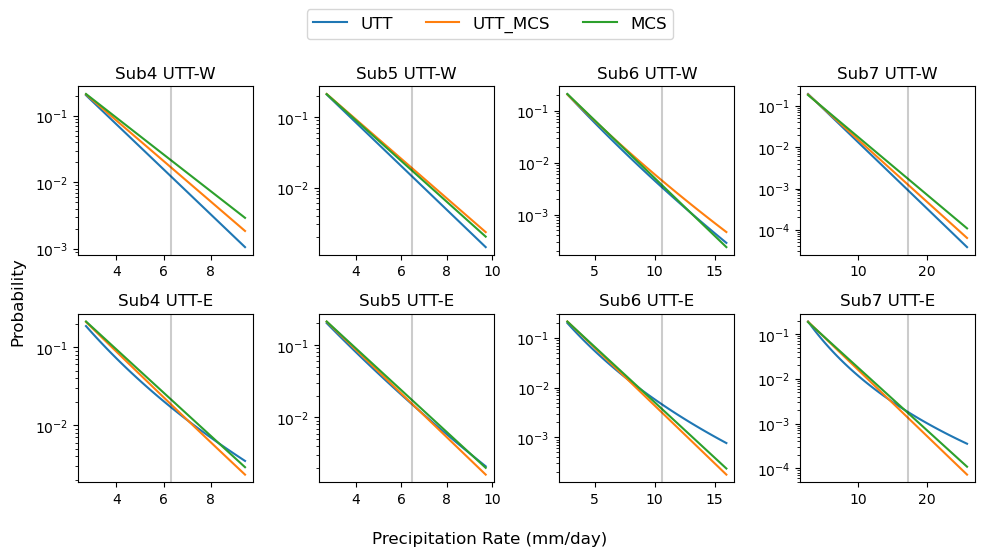

In [58]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(241)
ax.set_title('Sub4 UTT-W')
draw_west_pdf(ax, sub_id=4)
ax = fig.add_subplot(242)
ax.set_title('Sub5 UTT-W')
draw_west_pdf(ax, sub_id=5)
ax = fig.add_subplot(243)
ax.set_title('Sub6 UTT-W')
draw_west_pdf(ax, sub_id=6)
ax = fig.add_subplot(244)
ax.set_title('Sub7 UTT-W')
draw_west_pdf(ax, sub_id=7)
ax = fig.add_subplot(245)
ax.set_title('Sub4 UTT-E')
draw_east_pdf(ax, sub_id=4)
ax = fig.add_subplot(246)
ax.set_title('Sub5 UTT-E')
draw_east_pdf(ax, sub_id=5)
ax = fig.add_subplot(247)
ax.set_title('Sub6 UTT-E')
draw_east_pdf(ax, sub_id=6)
ax = fig.add_subplot(248)
ax.set_title('Sub7 UTT-E')
draw_east_pdf(ax, sub_id=7)
fig.supxlabel('Precipitation Rate (mm/day)')
fig.supylabel('Probability')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=[0.5, 1.1], fontsize=12)
plt.tight_layout()
plt.savefig('UTT-MCS.png', dpi=120, bbox_inches='tight')
plt.show()

# UTT without MCS

In [59]:
def get_UTTwoMCS(sub_id):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    threshold = np.quantile(sub_precip, .95)
    bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
    tutt_sub = np.load(str(sub_id)+'_all_TUTT-10degree.npy')
    tutt_type = np.load(str(sub_id)+'_all_TUTT-types-10degree.npy')
    tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
    surge_sub = np.load(str(sub_id)+'_all_surge.npy')
    midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
    mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
    front_sub = np.load(str(sub_id)+'_all_front.npy')
    x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
    tutt_precip = []
    mcs_precip = []
    west_utt_precip = []
    east_utt_precip = []
    # two-way
    tutt_mcs_precip = []
    west_utt_mcs_precip = []
    east_utt_mcs_precip = []
    tutt_wo_mcs_precip = []
    west_utt_wo_mcs_precip = []
    east_utt_wo_mcs_precip = []
    for i in range(sub_precip.shape[0]):
        if tutt_sub[i]>0:
            tutt_precip.append(sub_precip[i])
            if tutt_type[i]>0:
                west_utt_precip.append(sub_precip[i])
            if tutt_type[i]<0:
                east_utt_precip.append(sub_precip[i])
        if mcs_sub[i]>0:
            mcs_precip.append(sub_precip[i])
        # 2-way
        if tutt_sub[i]>0 and mcs_sub[i]>0:
            tutt_mcs_precip.append(sub_precip[i])
            if tutt_type[i]>0:
                west_utt_mcs_precip.append(sub_precip[i])
            if tutt_type[i]<0:
                east_utt_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and mcs_sub[i]<=0:
            tutt_wo_mcs_precip.append(sub_precip[i])
            if tutt_type[i]>0:
                west_utt_wo_mcs_precip.append(sub_precip[i])
            if tutt_type[i]<0:
                east_utt_wo_mcs_precip.append(sub_precip[i])
    return x, threshold, mcs_precip, tutt_precip, west_utt_precip, east_utt_precip, tutt_wo_mcs_precip, west_utt_wo_mcs_precip, east_utt_wo_mcs_precip

In [60]:
def draw_west_pdf(ax, sub_id):
    x, threshold, mcs_precip, tutt_precip, west_utt_precip, east_utt_precip, tutt_wo_mcs_precip, west_utt_wo_mcs_precip, east_utt_wo_mcs_precip = get_UTTwoMCS(sub_id=sub_id)
    x, threshold, west_utt_precip, east_utt_precip, mcs_precip, west_utt_mcs_precip, east_utt_mcs_precip = get_utt_mcs(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_wo_mcs_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='UTTwoMCS')
    else:
        ax.plot(x, pdf2, label='UTTwoMCS')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_mcs_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='UTTwMCS')
    else:
        ax.plot(x, pdf2, label='UTTwMCS')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='MCS')
    else:
        ax.plot(x, pdf2, label='MCS')
    # ax.legend()
    ax.axvline(x=threshold, ymin=0, ymax=1, color='k', alpha=0.2)
    ax.set_yscale('log')
def draw_east_pdf(ax, sub_id):
    x, threshold, mcs_precip, tutt_precip, west_utt_precip, east_utt_precip, tutt_wo_mcs_precip, west_utt_wo_mcs_precip, east_utt_wo_mcs_precip = get_UTTwoMCS(sub_id=sub_id)
    x, threshold, west_utt_precip, east_utt_precip, mcs_precip, west_utt_mcs_precip, east_utt_mcs_precip = get_utt_mcs(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_wo_mcs_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='UTTwoMCS')
    else:
        ax.plot(x, pdf2, label='UTTwoMCS')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_mcs_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='UTTwMCS')
    else:
        ax.plot(x, pdf2, label='UTTwMCS')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
    if score_ga<score_gp:
        ax.plot(x, pdf1, label='MCS')
    else:
        ax.plot(x, pdf2, label='MCS')
    # ax.legend()
    ax.axvline(x=threshold, ymin=0, ymax=1, color='k', alpha=0.2)
    ax.set_yscale('log')

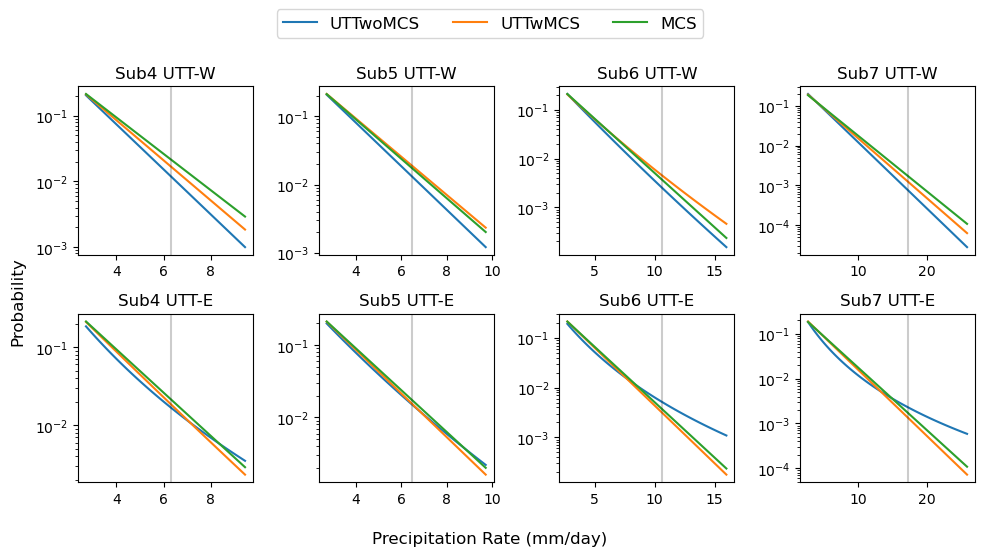

In [61]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(241)
ax.set_title('Sub4 UTT-W')
draw_west_pdf(ax, sub_id=4)
ax = fig.add_subplot(242)
ax.set_title('Sub5 UTT-W')
draw_west_pdf(ax, sub_id=5)
ax = fig.add_subplot(243)
ax.set_title('Sub6 UTT-W')
draw_west_pdf(ax, sub_id=6)
ax = fig.add_subplot(244)
ax.set_title('Sub7 UTT-W')
draw_west_pdf(ax, sub_id=7)
ax = fig.add_subplot(245)
ax.set_title('Sub4 UTT-E')
draw_east_pdf(ax, sub_id=4)
ax = fig.add_subplot(246)
ax.set_title('Sub5 UTT-E')
draw_east_pdf(ax, sub_id=5)
ax = fig.add_subplot(247)
ax.set_title('Sub6 UTT-E')
draw_east_pdf(ax, sub_id=6)
ax = fig.add_subplot(248)
ax.set_title('Sub7 UTT-E')
draw_east_pdf(ax, sub_id=7)
fig.supxlabel('Precipitation Rate (mm/day)')
fig.supylabel('Probability')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=[0.5, 1.1], fontsize=12)
plt.tight_layout()
# plt.savefig('UTT-MCS.png', dpi=120, bbox_inches='tight')
plt.show()

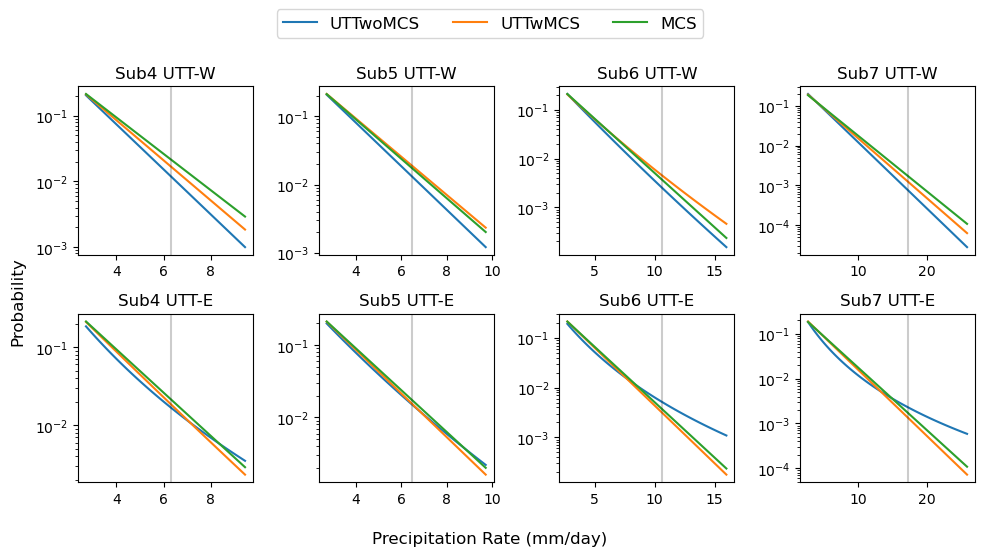

In [62]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(241)
ax.set_title('Sub4 UTT-W')
draw_west_pdf(ax, sub_id=4)
ax = fig.add_subplot(242)
ax.set_title('Sub5 UTT-W')
draw_west_pdf(ax, sub_id=5)
ax = fig.add_subplot(243)
ax.set_title('Sub6 UTT-W')
draw_west_pdf(ax, sub_id=6)
ax = fig.add_subplot(244)
ax.set_title('Sub7 UTT-W')
draw_west_pdf(ax, sub_id=7)
ax = fig.add_subplot(245)
ax.set_title('Sub4 UTT-E')
draw_east_pdf(ax, sub_id=4)
ax = fig.add_subplot(246)
ax.set_title('Sub5 UTT-E')
draw_east_pdf(ax, sub_id=5)
ax = fig.add_subplot(247)
ax.set_title('Sub6 UTT-E')
draw_east_pdf(ax, sub_id=6)
ax = fig.add_subplot(248)
ax.set_title('Sub7 UTT-E')
draw_east_pdf(ax, sub_id=7)
fig.supxlabel('Precipitation Rate (mm/day)')
fig.supylabel('Probability')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=[0.5, 1.1], fontsize=12)
plt.tight_layout()
# plt.savefig('UTT-MCS.png', dpi=120, bbox_inches='tight')
plt.show()

In [63]:
def draw_west_gp(ax, sub_id):
    x, threshold, mcs_precip, tutt_precip, west_utt_precip, east_utt_precip, tutt_wo_mcs_precip, west_utt_wo_mcs_precip, east_utt_wo_mcs_precip = get_UTTwoMCS(sub_id=sub_id)
    x, threshold, west_utt_precip, east_utt_precip, mcs_precip, west_utt_mcs_precip, east_utt_mcs_precip = get_utt_mcs(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_wo_mcs_precip, None, x)
    ax.plot(x, pdf2, label='UTTwoMCS')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(west_utt_mcs_precip, None, x)
    ax.plot(x, pdf2, label='UTTwMCS')
    print(sub_id, score_ga, score_gp)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
    ax.plot(x, pdf2, label='MCS')
    # ax.legend()
    ax.axvline(x=threshold, ymin=0, ymax=1, color='k', alpha=0.2)
    ax.set_yscale('log')
def draw_east_gp(ax, sub_id):
    x, threshold, mcs_precip, tutt_precip, west_utt_precip, east_utt_precip, tutt_wo_mcs_precip, west_utt_wo_mcs_precip, east_utt_wo_mcs_precip = get_UTTwoMCS(sub_id=sub_id)
    x, threshold, west_utt_precip, east_utt_precip, mcs_precip, west_utt_mcs_precip, east_utt_mcs_precip = get_utt_mcs(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_wo_mcs_precip, None, x)
    ax.plot(x, pdf2, label='UTTwoMCS')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(east_utt_mcs_precip, None, x)
    ax.plot(x, pdf2, label='UTTwMCS')
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
    ax.plot(x, pdf2, label='MCS')
    # ax.legend()
    ax.axvline(x=threshold, ymin=0, ymax=1, color='k', alpha=0.2)
    ax.set_yscale('log')

4 44.23493859264444 39.006498704345816
5 333.5659625162059 303.59197436452496
6 610.2192345067657 592.1283448201054
7 970.4781435307763 1029.5373858320968


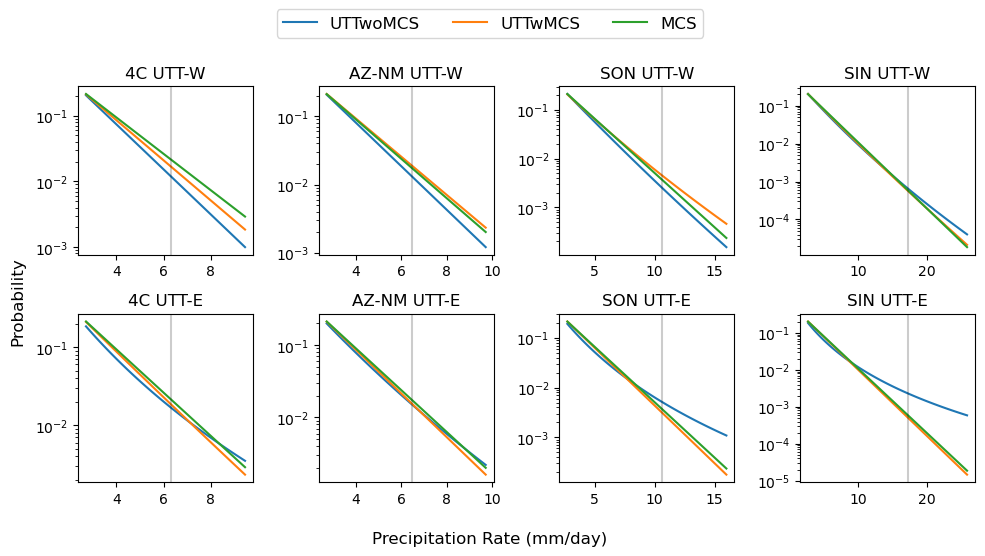

In [64]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(241)
ax.set_title('4C UTT-W')
draw_west_gp(ax, sub_id=4)
ax = fig.add_subplot(242)
ax.set_title('AZ-NM UTT-W')
draw_west_gp(ax, sub_id=5)
ax = fig.add_subplot(243)
ax.set_title('SON UTT-W')
draw_west_gp(ax, sub_id=6)
ax = fig.add_subplot(244)
ax.set_title('SIN UTT-W')
draw_west_gp(ax, sub_id=7)
ax = fig.add_subplot(245)
ax.set_title('4C UTT-E')
draw_east_gp(ax, sub_id=4)
ax = fig.add_subplot(246)
ax.set_title('AZ-NM UTT-E')
draw_east_gp(ax, sub_id=5)
ax = fig.add_subplot(247)
ax.set_title('SON UTT-E')
draw_east_gp(ax, sub_id=6)
ax = fig.add_subplot(248)
ax.set_title('SIN UTT-E')
draw_east_gp(ax, sub_id=7)
fig.supxlabel('Precipitation Rate (mm/day)')
fig.supylabel('Probability')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=[0.5, 1.1], fontsize=12)
plt.tight_layout()
plt.savefig('UTT-MCS-GenPareto.png', dpi=120, bbox_inches='tight')
plt.show()

In [ ]:
c = 0.1
x = np.linspace(1, 10, 100)
y = (1+c*x)**(-1-1/c)
plt.plot(x, y, label='c=0.1')
c = 1
y = (1+c*x)**(-1-1/c)
plt.plot(x, y, label='c=1.0')
c = 5
y = (1+c*x)**(-1-1/c)
plt.plot(x, y, label='c=5')
c = 10
y = (1+c*x)**(-1-1/c)
plt.plot(x, y, label='c=10')
plt.yscale('log')
plt.legend()